# Get config for spherix

This notebook will allow visualization of the dataset and generate the config txt file to use with the spherix library.

In [87]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [88]:
edge_df = pd.read_csv('edge_trajectories.csv')
edge_df.head()

,Unnamed: 0,vehicle_id,time,x,y
0,0,flow_1.0,0,5.100000,-4.8
1,2,flow_1.0,1,7.129624,-4.8
2,3,flow_1.1,1,5.100000,-1.6
3,4,flow_1.2,1,5.100000,-8.0
4,6,flow_1.0,2,11.113675,-4.8


In [89]:
all_vehicle_ids = edge_df['vehicle_id'].unique()
chosen_vehicle_ids = np.random.choice(all_vehicle_ids, 200, replace=False)
traj_lens = np.zeros((200,))

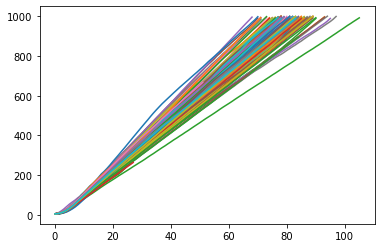

In [90]:
for i, id in enumerate(chosen_vehicle_ids):
    x_traj = edge_df[edge_df['vehicle_id'] == id]['x'].values
    y_traj = edge_df[edge_df['vehicle_id'] == id]['y'].values
    traj_lens[i] = len(edge_df[edge_df['vehicle_id'] == id].index)
    plt.plot(x_traj)

In [91]:
opt_traj_len = 60
dfx = np.zeros((100, opt_traj_len))
dfy = np.zeros((100, opt_traj_len))
dfx = dfx - np.tile(dfx[:,0], (opt_traj_len,1)).T
dfy = dfy - np.tile(dfy[:,0], (opt_traj_len,1)).T
j = 0
for i, id in enumerate(chosen_vehicle_ids):
    if j == 100:
        break
    if traj_lens[i] < 60:
        print('Skip trajectory {:d}'.format(i))
        continue
    else:
        x_traj = edge_df[edge_df['vehicle_id'] == id]['x'].values
        y_traj = edge_df[edge_df['vehicle_id'] == id]['y'].values
        dfx[j, :opt_traj_len] = x_traj[:opt_traj_len]
        dfy[j, :opt_traj_len] = y_traj[:opt_traj_len]
        j += 1
print('Valid trajectories: {:d}'.format(j))

Skip trajectory 2
Skip trajectory 5
Skip trajectory 18
Skip trajectory 21
Skip trajectory 26
Skip trajectory 29
Skip trajectory 39
Skip trajectory 50
Skip trajectory 55
Skip trajectory 63
Skip trajectory 65
Skip trajectory 68
Skip trajectory 73
Skip trajectory 78
Skip trajectory 79
Skip trajectory 85
Skip trajectory 86
Skip trajectory 95
Skip trajectory 100
Skip trajectory 103
Skip trajectory 104
Skip trajectory 105
Skip trajectory 109
Valid trajectories: 100


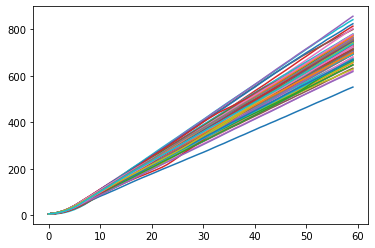

In [92]:
for i in range(100):
    plt.plot(dfx[i,:])

In [100]:
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA
fdx = skfda.FDataGrid(dfx, np.arange(dfx.shape[1]))
fpcax = FPCA(n_components=5)
fpcax.fit(fdx)

FPCA(n_components=5,
     weights=array([0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5]))

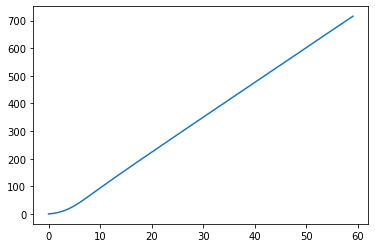

In [104]:
mean_x = fpcax.mean_.data_matrix.ravel()
plt.plot(mean_x)

In [113]:
basis_x = fpcax.components_.data_matrix.reshape(fpcax.components_.data_matrix.shape[:2])

In [114]:
scores_x = fpcax.transform(fdx)

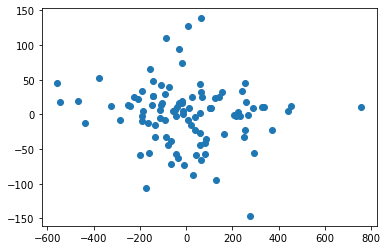

In [118]:
plt.scatter(scores_x[:,0], scores_x[:,1])

In [120]:
scores_x_var = np.var(scores_x, axis = 0)
scores_x_var

array([44635.24665622,  1984.555781  ,   393.05957153,   180.83892681,
          71.35645222])

Start writing to the config file

In [127]:
def vector_to_text(v):
    line_to_write = ''
    for m in v:
        line_to_write += (str(m) + ',')
    line_to_write = line_to_write[:len(line_to_write)-1]
    return line_to_write

In [129]:
file1 = open("spherixcfg.txt", "w") 
# first, write the mean_x
file1.write(vector_to_text(mean_x) + '\n')
# second, write the basis_x
for i in range(basis_x.shape[0]):
    file1.write(vector_to_text(basis_x[i,:]) + '\n')
# third, write the PCA scores covariance matrix
pca_scores_cov_x = np.diag(scores_x_var)
for i in range(basis_x.shape[0]):
    file1.write(vector_to_text(pca_scores_cov_x[i,:]) + '\n')
# finally, write the measurement error
file1.write(str(0.0001))
file1.close() 